**Generating ECG data for neural network analysis**

I am using the [MIT Arrythmia Database](https://www.physionet.org/physiobank/database/mitdb/). This database is a publicly available non-personally identifiable database of ECG signals that have been annotated by professional cardiologists. The data was collected at the Beth Israel Hospital in Boston in the late 70's.

I am using the [WFDB package](https://github.com/MIT-LCP/wfdb-python) from Physionet that enables the import of raw ECG data using Python 

In [1]:
import numpy as np
import wfdb
from wfdb import processing
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
dir = "mitdb" #this is the MIT-BIH arrythmia database
records = wfdb.get_record_list(dir)
print("The database contains %s records" %(len(records)))

The database contains 48 records


I will first take a look at an individual record to understand what is in the data. Each ECG record comprises two files: a data file and a corresponding annotations file.

In [3]:
recordnumber = "201"
ecgdata, fields = wfdb.rdsamp(recordnumber, pb_dir = dir, channels = [0]) 
fs = fields["fs"] 
print("The sample frequency is %s " %(fs))

The sample frequency is 360 


In [4]:
annotations = wfdb.rdann(recordnumber, "atr", pb_dir = dir)
samples = annotations.sample
symbols = annotations.symbol
print("There are %s annotations in record %s" %(len(samples), recordnumber))

There are 2039 annotations in record 201


ECG data is just measurement of voltage output of the leads attatched to the body measuring the electrical signal of the heart. Lets graph one of the heartbeats.

Text(0.5, 0, 'Time (s)')

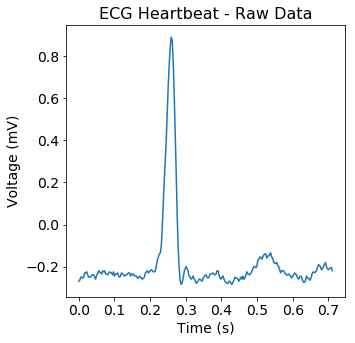

In [28]:
n = 150

before_r = 92
after_r = 164

x = np.linspace(0,0.711,256)
record_segment = ecgdata[samples[n]-before_r: samples[n]+after_r]
plt.figure(figsize=(5,5))
plt.plot(x,record_segment)
plt.title('ECG Heartbeat - Raw Data', fontsize=16)

plt.ylabel("Voltage (mV)",fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Time (s)",fontsize=14)

We are going to create a Pandas dataframe containing all of the annotations for all of the ECG signals in the database.

In [6]:
from tqdm import tqdm

all_annotations = pd.DataFrame()

for record in tqdm(records):
    
    an = wfdb.rdann(record, "atr", pb_dir = dir)
    
    for symbol in an.symbol:
        
        all_annotations = all_annotations.append({"annotation":symbol}, ignore_index = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [01:42<00:00,  2.65s/it]


In [7]:
print(len(all_annotations))

112647


Lets take a look at how many of each kind of annotation are in the database.

In [8]:
all_annotations["annotation"].value_counts()

N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: annotation, dtype: int64

A convolutional neural network is a powerful way to perform image classification. So we need to convert the ECG data, which is just a long series of voltage measurements into grayscale image files.

Lets start by doing that for one heartbeat.

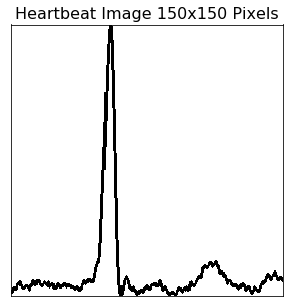

In [29]:
size = 256


max_val = record_segment.max()
min_val = record_segment.min()

scaled_segment = (record_segment - min_val)*size/(max_val - min_val)
scaled_segment = size - scaled_segment
scaled_segment = scaled_segment.astype("uint16")

x = np.arange(size)

array = np.column_stack((x,scaled_segment))

img = np.zeros([size,size,3], dtype="uint8")

img[:]=255

cv2.polylines(img,[array],False,(0,0,0), thickness=2)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title('Heartbeat Image 150x150 Pixels', fontsize=16)
plt.xticks([])
plt.yticks([])
plt.show()

Create folders for each beat type. For beat type "/" we will change the name because this is a windows operating system character. Because there is an "A" and an "a" we will change the name of "a" so that these aren't confused.

In [10]:
target_symbols = ['N','L','R','V','/','A','!','E','j','a','x']
base_path = "ecg_images/"

for symbol in target_symbols: 
    
    if symbol == '/': symbol = 'P'
    if symbol == 'a': symbol = 'B'
    if symbol == '!': symbol = 'F'
        
    path = base_path + symbol
    if not os.path.exists(path):
        
        os.makedirs(path)
    

The following function takes a segment of the ECG signal and the symbol and counter and creates an image in the relevant folder.

In [11]:
def create_image(record_segment, symbol, img_counter):
    
    size = 256

    max_val = record_segment.max()
    min_val = record_segment.min()

    scaled_segment = (record_segment - min_val)*256/(max_val - min_val)
    scaled_segment = size - scaled_segment
    scaled_segment = scaled_segment.astype("uint16")

    x = np.arange(size)

    array = np.column_stack((x,scaled_segment))

    img = np.zeros([size,size,3], dtype="uint8")

    img[:]=255

    cv2.polylines(img,[array],False,(0,0,0), thickness=2)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    path = "ecg_images/" + str(symbol) + "/"
    name = path + symbol + str(img_counter) + ".jpg"
    cv2.imwrite(name, img)
    

The following cycles through every annotated beat in the database, calls the function to create an image which is then saved in the relevant folder.

In [12]:
img_counter = 0

for record in tqdm(records):
    
    ecgdata, fields = wfdb.rdsamp(record, pb_dir = dir, channels = [0]) 
    an = wfdb.rdann(record, "atr", pb_dir = dir)
    
    for i, symbol in enumerate(an.symbol):
        
        if symbol in target_symbols:
            
            start = an.sample[i] - before_r
            end = an.sample[i] + after_r
            
            if start < 0 or end > 650000:
                continue 
                
            record_segment = ecgdata[start:end]
            
            if symbol == '/': symbol = 'P'
            if symbol == 'a': symbol = 'B'
            if symbol == '!': symbol = 'F'
            
            create_image(record_segment, symbol, img_counter)
            img_counter += 1
    

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [08:38<00:00, 12.00s/it]


A machine learning model is trained on training data, and its performance is measured during training on a validation data set. The accuracy of the final model is tested on a separate data set called the test set. 

We will now create test, validation, and training folders. 

We will only look at beats that have a sufficient amount of data for analysis, specifically:

* N: Normal beat
* L: Left bundle branch block beat
* R: Right bundle branch block beat
* V: Premature ventricular contraction
* P: Pause 
* A: Atrial premature beat

In [13]:
base_path = "ecg_images"

#create training directory
train_dir = os.path.join(base_path, 'train')

if not os.path.exists(train_dir):
        
        os.makedirs(train_dir)

#create validation directory
validation_dir = os.path.join(base_path, 'validation')

if not os.path.exists(validation_dir):
        
        os.makedirs(validation_dir)

#create test directory
test_dir = os.path.join(base_path, 'test')

if not os.path.exists(test_dir):
        
        os.makedirs(test_dir)

We will now create sub folders for each beat type within the training, validation, and test folders.

In [14]:
target_symbols = ['N','L','R','V','P','A','F','E','j','B','x'] # with replacement symbols

for symbol in target_symbols:
    
    path = os.path.join(train_dir, str(symbol))
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    path = os.path.join(validation_dir, str(symbol))
    
    if not os.path.exists(path):
        os.makedirs(path)
        
    path = os.path.join(test_dir, str(symbol))
    
    if not os.path.exists(path):
        os.makedirs(path)

Its typical in machine learning to allocate 80% of the data to training, and 10% each to validation and test. We will first shuffle the data to ensure there is no bias in this allocation.

In [15]:
import shutil

for symbol in target_symbols: 
    
    path = os.path.join(base_path, str(symbol))

    fnames = os.listdir(path)
    
    file_count = len(fnames)
    
    np.random.shuffle(fnames)
    
    for fname in fnames[0:int(0.8*file_count)]: 
        src = os.path.join(path, fname)
        train_symbol_path = os.path.join(train_dir, str(symbol))
        dst = os.path.join(train_symbol_path, fname)
        shutil.copyfile(src, dst)
    
    for fname in fnames[int(0.8*file_count):int(0.9*file_count)]: 
        src = os.path.join(path, fname)
        validation_symbol_path = os.path.join(validation_dir, str(symbol))
        dst = os.path.join(validation_symbol_path, fname)
        shutil.copyfile(src, dst)
        
    for fname in fnames[int(0.9*file_count):file_count]: 
        src = os.path.join(path, fname)
        test_symbol_path = os.path.join(test_dir, str(symbol))
        dst = os.path.join(test_symbol_path, fname)
        shutil.copyfile(src, dst)

In [16]:
for symbol in target_symbols:
    
    train_symbol_dir = os.path.join(train_dir, str(symbol))
    validation_symbol_dir = os.path.join(validation_dir, str(symbol))
    test_symbol_dir = os.path.join(test_dir, str(symbol))
    
    print(str(symbol) + " training: " + str(len(os.listdir(train_symbol_dir))))
    print(str(symbol) + " validation: " + str(len(os.listdir(validation_symbol_dir))))
    print(str(symbol) + " test: " + str(len(os.listdir(test_symbol_dir))))

N training: 60017
N validation: 7502
N test: 7503
L training: 6457
L validation: 807
L test: 808
R training: 5804
R validation: 725
R test: 726
V training: 5703
V validation: 713
V test: 713
P training: 5620
P validation: 702
P test: 703
A training: 2036
A validation: 255
A test: 255
F training: 377
F validation: 47
F test: 48
E training: 84
E validation: 11
E test: 11
j training: 183
j validation: 23
j test: 23
B training: 120
B validation: 15
B test: 15
x training: 154
x validation: 19
x test: 20


We now have our data ready for the neural network to analyze!